In [1]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
from pathlib import Path
import matplotlib as mpl
import random
from numba import njit

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def WIS(X,y, quantiles=[0.01,0.025,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.60,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.975,0.99]):
    #X is the matrix of trajectories
    #calculate quantiles
    Q = np.quantile(X,quantiles,axis=0)
    WIS = np.zeros(X.shape[1])
    for i in range(len(quantiles) // 2):
        interval_range = 100*(quantiles[-i-1]-quantiles[i])
        alpha = 1-(quantiles[-i-1]-quantiles[i])
        IS = interval_score(y,Q[i],Q[-i-1],interval_range)
        WIS += IS['interval_score']*alpha/2
    WIS += 0.5*np.abs(Q[11] - y)
        
    return np.sum(WIS) / (len(quantiles) // 2 + 0.5)

In [4]:
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


# proper vs strictly proper for SIR curve

In [5]:
# SIR Model in homogeneous single population
# input is the number of stochastic simulations to run, the transmissibility parameter, the recovery rate, 
# population size, and number of initially infected individuals
def SIR_model(nsim, beta, mu, pop, nseed):
    Sall = {}
    Iall = {}
    Rall = {}
    for sim in range(nsim):
        numsus = []
        numinf = []
        numrec = []
    
        numsus.append(pop)

        # initial conditions
        numsus[0] = pop-nseed
        numinf.append(nseed)
        numrec.append(0)
    
        t=0
        while numinf[t]> 0 :
            t+=1
        
            S = numsus[t-1]
            I = numinf[t-1]
            R = numrec[t-1]
            Nnew = S + I + R
            
            # simulate infection in the subpopulation    
            foi = 1 - ((1 - beta/Nnew)**(I) ) # force of infection
            
            ainf = np.random.binomial(S, min(1,foi)) # transmission
            arec = np.random.binomial(I, min(1,mu)) # recovery
            
            # update compartments
            S = S - ainf 
            I = I + ainf - arec
            R = R + arec
        
            # create time series of compartment counts
            numsus.append(S)
            numinf.append(I)
            numrec.append(R)
       
        # save all simulations in a dictionary
        Sall[sim] = numsus
        Iall[sim] = numinf
        Rall[sim] = numrec
        
    return Sall, Iall, Rall



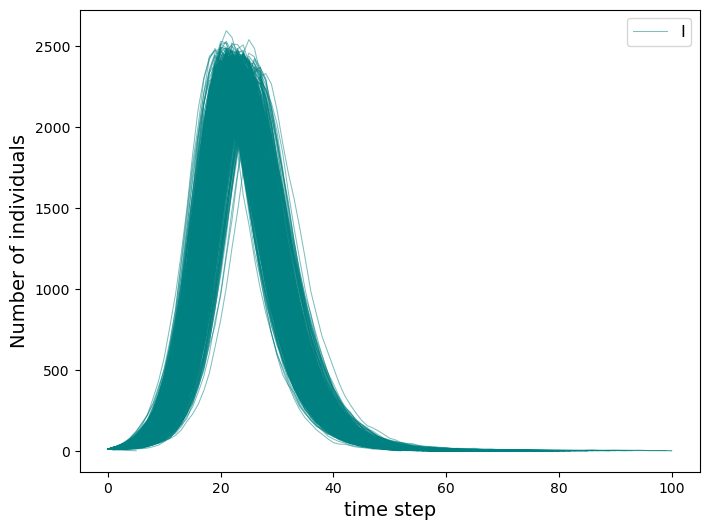

In [6]:
# example trajectories from SIR model
plt.figure(figsize=(8,6))
sim =1000
Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)
for n in range(sim):
    plt.plot(Iall[n], 'teal',linewidth=.75,  alpha=.5)
    
plt.plot(Iall[n], 'teal',linewidth=.75, label='I', alpha=.5)

plt.legend(fontsize=12)
plt.xlabel('time step', fontsize=14)
plt.ylabel('Number of individuals', fontsize=14)


plt.show()

In [12]:
# only keep first 60 time steps
n=0
Ifilt = {}
for i in Iall.keys():
    if len(Iall[i])>=60:
        Ifilt[n] = Iall[i][0:60]
        n+=1

In [13]:
# save infection trajectories in dataframe
Idf = pd.DataFrame()

time = list(range(1, 61))

for it in range(1, 101):
    traj = Ifilt[it]
    
    for t in time:
        val = traj[t-1]
        
        newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
        
        Idf = pd.concat([Idf, newrow])
    

In [14]:

Ishift = pd.DataFrame()
for idx in Idf.trajectory_id.unique():
    d = Idf[Idf.trajectory_id==idx]
    d['I'] = d['I'] *2
    
    d['I'] = d['I'].apply(lambda key:  0 if key<0 else key)
    
   # d['time'] = d['time'] + np.random.randint(-20, high=20)
    
    Ishift = pd.concat([Ishift,d])
    


Text(0, 0.5, 'Number of infectious individual')

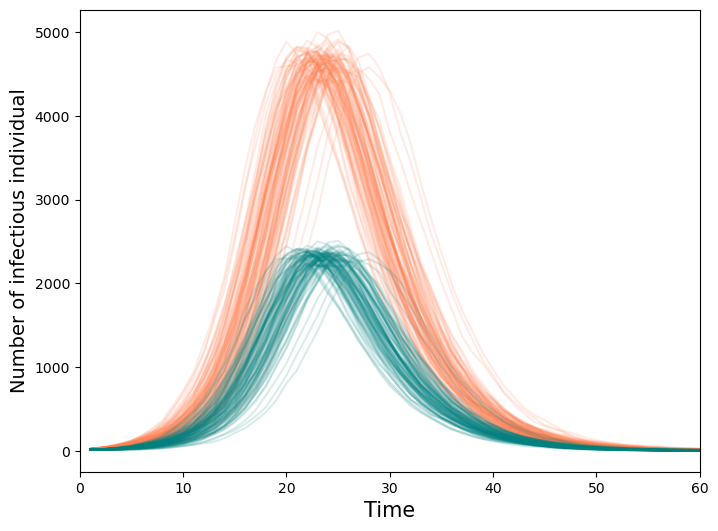

In [15]:
# plot of uncorrelated trajectories
plt.figure(figsize=(8,6))
for i in Ishift.trajectory_id.unique():
    if i<500:
        d = Ishift[Ishift.trajectory_id==i]
        plt.plot(d.time, d.I, color='coral', alpha=.15)
        
for i in Idf.trajectory_id.unique():
    if i<500:
        d = Idf[Idf.trajectory_id==i]
        plt.plot(d.time, d.I, color='teal', alpha=.15)
        
        
plt.xlim([0,60])

plt.xlabel('Time',fontsize=15)
plt.ylabel('Number of infectious individual', fontsize=14)

(0.0, 70.0)

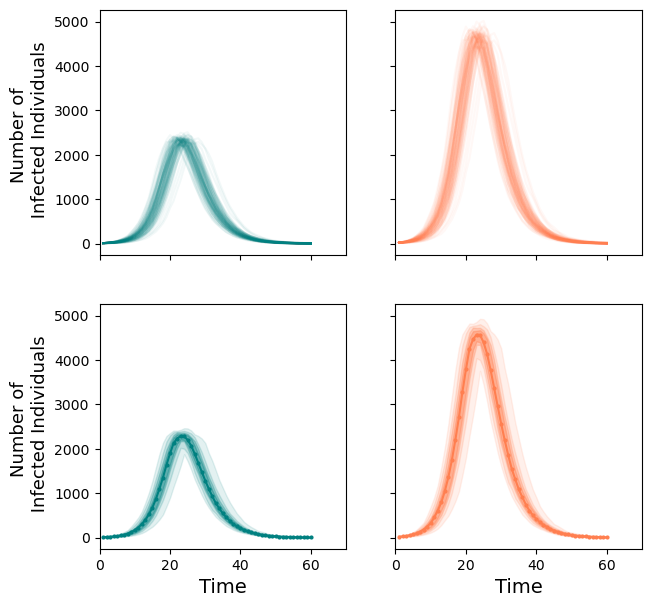

In [16]:
Ishift = Ishift.sort_values(by='time',ascending=True)

# plot all trajectories
fig,ax = plt.subplots(2,2, figsize=(7,7), sharey=True,sharex=True)

plt.subplot(2,2,1)
for i in Idf.trajectory_id.unique():
    if i<501:
        d = Idf[Idf.trajectory_id==i]
        plt.plot(d.time, d.I, color='teal', alpha=.05)
#plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of \n Infected Individuals', fontsize=13)
        

plt.subplot(2,2,2)
for i in Ishift.trajectory_id.unique():
    if i<501:
        d = Ishift[Ishift.trajectory_id==i]
        plt.plot(d.time, d.I, color='coral', alpha=.05)
#plt.xlabel('Time', fontsize=14)        
        
        
plt.subplot(2,2,3)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Idf.groupby('time')['I'].quantile(q[0]))
    qlow = list(Idf.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Idf.time.unique(),qupp,qlow, color='teal', alpha=alpha)
    
qmed = list(Idf.groupby('time')['I'].quantile(.5))

plt.plot(Idf.time.unique(),qmed,'-o', color='teal', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of \n Infected Individuals', fontsize=13)
 

plt.subplot(2,2,4)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Ishift.groupby('time')['I'].quantile(q[0]))
    qlow = list(Ishift.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Ishift.time.unique(),qupp,qlow, color='coral', alpha=alpha)
    
qmed = list(Ishift.groupby('time')['I'].quantile(.5))

plt.plot(Ishift.time.unique(),qmed,'-o', color='coral', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
#plt.ylabel('Number of Infected Individuals', fontsize=13)
plt.xlim([0,70])

In [17]:
# run SIR model and generate time shifted trajectories

def get_SIR_trajectories(sim=1000):

    #sim =200
    Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)

    n=0
    Ifilt = {}
    for i in Iall.keys():
        if len(Iall[i])>=60:
            Ifilt[n] = Iall[i][0:60]
            n+=1

    Idf = pd.DataFrame()
    time = list(range(1, 61))

    for it in range(1, 101):
        traj = Ifilt[it]

        for t in time:
            val = traj[t-1]

            newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
            Idf = pd.concat([Idf, newrow])

    Ishift = pd.DataFrame()
    for idx in Idf.trajectory_id.unique():
        d = Idf[Idf.trajectory_id==idx]
       # d['time'] = d['time'] + 20
        
        d['I'] = d['I'] *2
    
        d['I'] = d['I'].apply(lambda key:  0 if key<0 else key)
               

        Ishift = pd.concat([Ishift,d])

    Idf['Model'] = 'SIR'
    Ishift['Model'] = 'magnitude shifted SIR'

    dftot = pd.concat([Idf, Ishift])
    
    dftot = dftot[(dftot.time>0) & (dftot.time<=60)]

    return dftot

In [18]:
# compute energy score and WIS for SIR and uncorrelated model
numit =100

ES_SIR = []
ES_shift = []
WIS_SIR = []
WIS_shift = []

truth = []
for i in range(numit):
    
    y=np.array([])
    while y.shape[0]<60:
        # generate observation vector as single instance of SIR model
        Sall,Iall, Rall = SIR_model(nsim=1, beta=.625,mu=.25, pop=10000, nseed=10)
        y = np.array(Iall[0][0:60]).astype(float) 
        
    dftot = get_SIR_trajectories(sim=800)

    SIRdf = dftot[dftot.Model=='SIR']
    SIR_X = np.array([np.array(SIRdf[SIRdf['trajectory_id'] == i].I) for i in SIRdf['trajectory_id'].unique()]).astype(float) 
    
    shiftdf = dftot[dftot.Model=='magnitude shifted SIR']
    shift_X = np.array([np.array(shiftdf[shiftdf['trajectory_id'] == i].I) for i in shiftdf['trajectory_id'].unique()]).astype(float) 

    # calculate scores
    ES_SIR.append(energyscore(SIR_X ,y))
    ES_shift.append(energyscore(shift_X,y))
    WIS_SIR.append(WIS(SIR_X,y))
    WIS_shift.append(WIS(shift_X,y))
    
    

In [19]:
ESdf = pd.DataFrame({'Model':'SIR', 'value':ES_SIR,'trajectory_id':list(SIRdf['trajectory_id'].unique())})
ESdf = pd.concat([ESdf,pd.DataFrame({'Model':'magnitude shifted SIR', 'value':ES_shift,
                                     'trajectory_id':list(shiftdf['trajectory_id'].unique())})])

WISdf = pd.DataFrame({'Model':'SIR', 'value':WIS_SIR,'trajectory_id':list(SIRdf['trajectory_id'].unique())})
WISdf = pd.concat([WISdf,pd.DataFrame({'Model':'magnitude shifted SIR', 'value':WIS_shift,
                                       'trajectory_id':list(shiftdf['trajectory_id'].unique())})])

In [20]:
ESdf

,Model,value,trajectory_id
0,SIR,814.470290,1
1,SIR,406.990461,2
2,SIR,384.050169,3
3,SIR,924.138658,4
4,SIR,376.433303,5
...,...,...,...
95,magnitude shifted SIR,6367.527150,96
96,magnitude shifted SIR,6364.379198,97
97,magnitude shifted SIR,6175.791833,98
98,magnitude shifted SIR,6109.764760,99


616.0362127503977
6351.925678916714
2876.087689130435
26866.906739130434


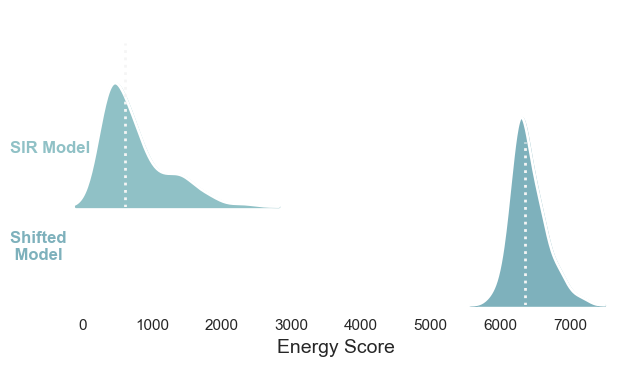

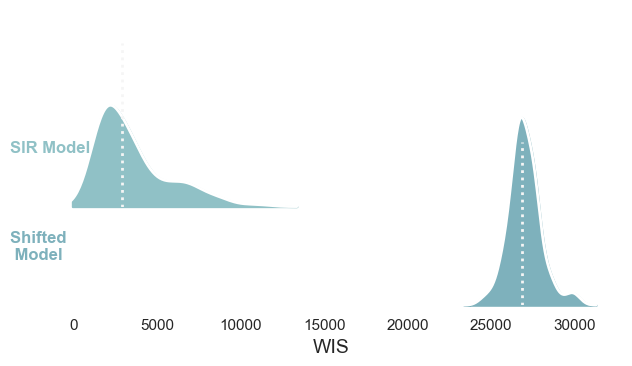

In [22]:
# plot distributions for energy score and WIS

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
dfs = [ESdf, WISdf]
scores = ['Energy Score', 'WIS']

i=1
#plt.subplots(1,2, figsize=(15,5))
for df in dfs:
    if i==1:
        maxi=10000
    else:
        maxi=110000
        
    df = df.copy()
    df['Model'] = df['Model'].apply(lambda x: 'SIR Model' if x == 'SIR' else 'Shifted \n Model')
    #plt.subplot(1,2,i)
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="Model", hue="Model", aspect=3.5, height=2, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "value",
          bw_adjust=1, clip_on=False,
          fill=True, alpha=1, linewidth=1.5, clip = (-100,maxi))
    g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=1, clip = (-500,maxi))


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-.05, .3, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "value")

    # Define a function to plot the median
    def plot_median(data, color, label):
        median = np.median(data['value'])
        plt.axvline(median,ymin=0, ymax=.83, color='whitesmoke', linestyle=':', linewidth=2)
        print(median)

    # Apply the function to plot the median
    g.map_dataframe(plot_median)


    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.5)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    plt.xlabel(scores[i-1], fontsize=14)
    
   

  #  plt.savefig(f'../figs/dist_SIRtest_{scores[i-1]}.pdf')
    
    
    i+=1
    
    

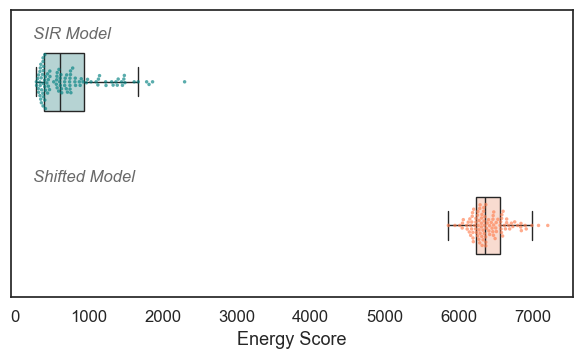

In [23]:
fig,ax = plt.subplots(figsize=(6,3.75))
palette = ['teal', 'coral']

df = ESdf.copy()


g=sns.boxplot(x='value', y='Model', data=df,hue='Model', width=0.4, showfliers=False, 
            palette=palette)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))


sns.swarmplot(x='value', y='Model', data=df,hue='Model', palette=palette,
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

a = 0
for mod in ['SIR Model', 'Shifted Model']:
    plt.text(250,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

#plt.xlim([0,3500])    
    
plt.xlabel('Energy Score', fontsize=13)
plt.xticks(fontsize=12)
#plt.legend(title=None)
plt.tight_layout()

#plt.savefig('../figs/sir_test_ES_boxplots_1115.pdf')
plt.show()

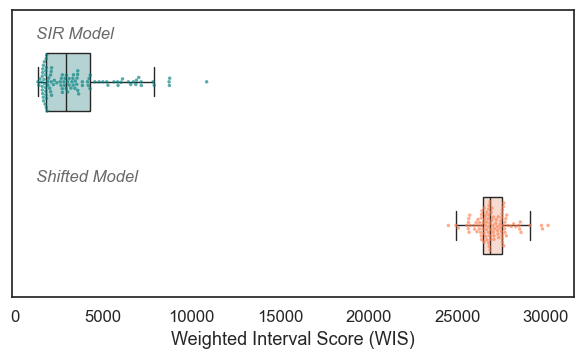

In [24]:
fig,ax = plt.subplots(figsize=(6,3.75))
palette = ['teal', 'coral']

df = WISdf.copy()

g=sns.boxplot(x='value', y='Model', data=WISdf,hue='Model', width=0.4, showfliers=False, 
            palette=palette)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))


sns.swarmplot(x='value', y='Model', data=WISdf,hue='Model', palette=palette,
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

#plt.xlim([0,17500])

a = 0
for mod in ['SIR Model', 'Shifted Model']:
    plt.text(1200,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

plt.xlabel('Weighted Interval Score (WIS)', fontsize=13)
plt.xticks(fontsize=12)
#plt.legend(title=None)
plt.tight_layout()
#plt.savefig('../figs/sir_test_WIS_boxplots_1115.pdf')
plt.show()

In [32]:
dfSIR = ESdf[ESdf.Model=='SIR']
dfshifted = ESdf[ESdf.Model=='magnitude shifted SIR'].rename(columns={'value':'ES_shifted'})

dfratio = dfSIR.merge(dfshifted,on=['trajectory_id'])
dfratio['ratio'] = dfratio['ES_shifted'] / dfratio['value']
dfratio['score'] = 'Energy Score'

dfSIR = WISdf[WISdf.Model=='SIR']
dfshifted = WISdf[WISdf.Model=='magnitude shifted SIR'].rename(columns={'value':'WIS_shifted'})

dfratio_WIS = dfSIR.merge(dfshifted,on=['trajectory_id'])
dfratio_WIS['ratio'] = dfratio_WIS['WIS_shifted'] / dfratio_WIS['value']
dfratio_WIS['score'] = 'WIS'

dfratio = pd.concat([dfratio,dfratio_WIS])

Text(-36.25, 0.5, '')

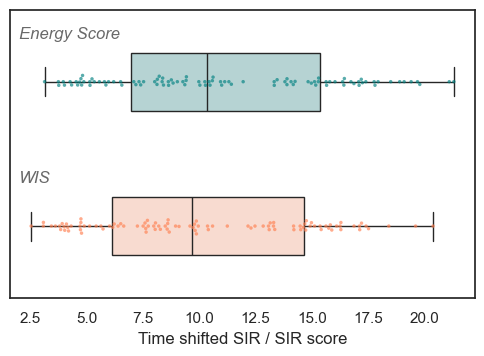

In [36]:
fig,ax = plt.subplots(figsize=(6,3.75))


palette = ['teal', 'coral']
g=sns.boxplot(x='ratio',y= 'score',data=dfratio,palette=palette,hue='score',width=.4)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))
    
sns.swarmplot(x='ratio',y= 'score',data=dfratio,palette=palette,hue='score',
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

a = 0
for mod in ['Energy Score', 'WIS']:
    plt.text(2,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1
    
    
plt.xlabel('Time shifted SIR / SIR score',fontsize=12)
plt.ylabel('')

In [ ]:
# random increase/decrease

In [37]:
# save infection trajectories in dataframe
Idf = pd.DataFrame()

time = list(range(1, 61))

for it in range(1, 101):
    traj = Ifilt[it]
    
    for t in time:
        val = traj[t-1]
        
        newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
        
        Idf = pd.concat([Idf, newrow])
    

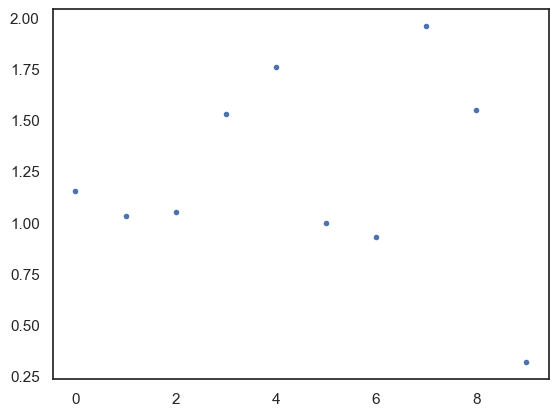

In [51]:
plt.plot(np.random.uniform(.2,2,10),'.')

In [54]:
# reshuffle trajectories to create uncorrelated model

Ishift = pd.DataFrame()
for idx in Idf.trajectory_id.unique():
    d = Idf[Idf.trajectory_id==idx]
     
    d['I'] = d['I'] * np.random.uniform(.25,1.75)
    
    d['I'] = d['I'].apply(lambda key:  0 if key<0 else key)
        
    
    Ishift = pd.concat([Ishift,d])
    
   

Text(0, 0.5, 'Number of infectious individual')

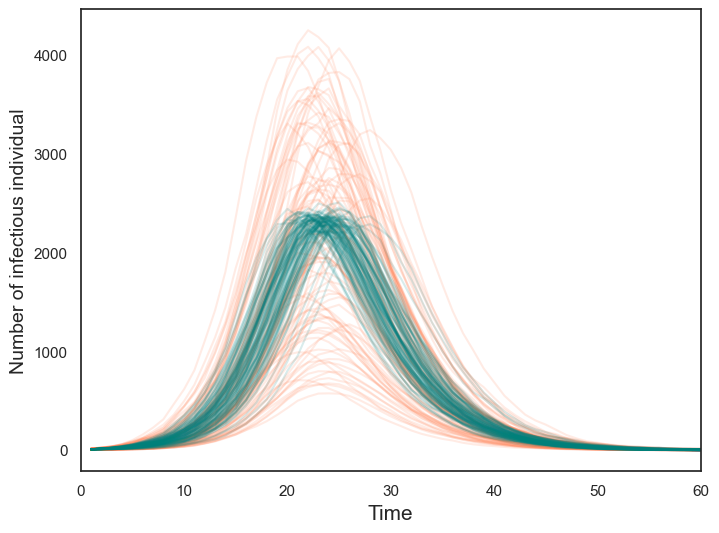

In [55]:
# plot of uncorrelated trajectories
plt.figure(figsize=(8,6))
for i in Ishift.trajectory_id.unique():
    if i<500:
        d = Ishift[Ishift.trajectory_id==i]
        plt.plot(d.time, d.I, color='coral', alpha=.15)
        
for i in Idf.trajectory_id.unique():
    if i<500:
        d = Idf[Idf.trajectory_id==i]
        plt.plot(d.time, d.I, color='teal', alpha=.15)
        
        
plt.xlim([0,60])

plt.xlabel('Time',fontsize=15)
plt.ylabel('Number of infectious individual', fontsize=14)

(0.0, 70.0)

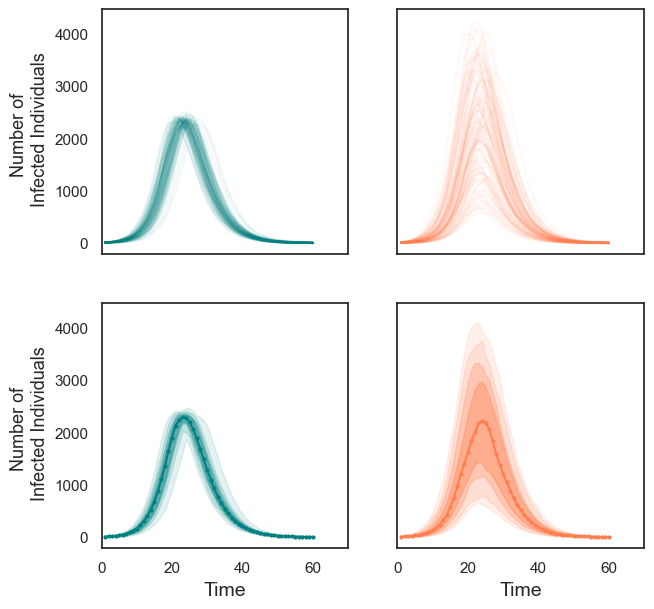

In [56]:
Ishift = Ishift.sort_values(by='time',ascending=True)

# plot all trajectories
fig,ax = plt.subplots(2,2, figsize=(7,7), sharey=True,sharex=True)

plt.subplot(2,2,1)
for i in Idf.trajectory_id.unique():
    if i<501:
        d = Idf[Idf.trajectory_id==i]
        plt.plot(d.time, d.I, color='teal', alpha=.05)
#plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of \n Infected Individuals', fontsize=13)
        

plt.subplot(2,2,2)
for i in Ishift.trajectory_id.unique():
    if i<501:
        d = Ishift[Ishift.trajectory_id==i]
        plt.plot(d.time, d.I, color='coral', alpha=.05)
#plt.xlabel('Time', fontsize=14)        
        
        
plt.subplot(2,2,3)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Idf.groupby('time')['I'].quantile(q[0]))
    qlow = list(Idf.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Idf.time.unique(),qupp,qlow, color='teal', alpha=alpha)
    
qmed = list(Idf.groupby('time')['I'].quantile(.5))

plt.plot(Idf.time.unique(),qmed,'-o', color='teal', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of \n Infected Individuals', fontsize=13)
 

plt.subplot(2,2,4)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Ishift.groupby('time')['I'].quantile(q[0]))
    qlow = list(Ishift.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Ishift.time.unique(),qupp,qlow, color='coral', alpha=alpha)
    
qmed = list(Ishift.groupby('time')['I'].quantile(.5))

plt.plot(Ishift.time.unique(),qmed,'-o', color='coral', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
#plt.ylabel('Number of Infected Individuals', fontsize=13)
plt.xlim([0,70])

In [57]:
# run SIR model and generate time shifted trajectories

def get_SIR_trajectories(sim=1000):

    #sim =200
    Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)

    n=0
    Ifilt = {}
    for i in Iall.keys():
        if len(Iall[i])>=60:
            Ifilt[n] = Iall[i][0:60]
            n+=1

    Idf = pd.DataFrame()
    time = list(range(1, 61))

    for it in range(1, 101):
        traj = Ifilt[it]

        for t in time:
            val = traj[t-1]

            newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
            Idf = pd.concat([Idf, newrow])

    Ishift = pd.DataFrame()
    for idx in Idf.trajectory_id.unique():
        d = Idf[Idf.trajectory_id==idx]
        
        d['I'] = d['I'] * np.random.uniform(.25,1.75)
    
        d['I'] = d['I'].apply(lambda key:  0 if key<0 else key)
    

        Ishift = pd.concat([Ishift,d])

    Idf['Model'] = 'SIR'
    Ishift['Model'] = 'magnitude shifted SIR'

    dftot = pd.concat([Idf, Ishift])
    
    dftot = dftot[(dftot.time>0) & (dftot.time<=60)]

    return dftot

In [158]:
ESdf

,Model,value
0,SIR,403.450413
1,SIR,618.317168
2,SIR,385.708206
3,SIR,520.654794
4,SIR,472.983108
...,...,...
95,time shifted SIR,5451.475286
96,time shifted SIR,5783.813297
97,time shifted SIR,5554.911029
98,time shifted SIR,5922.562206


In [58]:
# compute energy score and WIS for SIR and uncorrelated model
numit =100

ES_SIR = []
ES_shift = []
WIS_SIR = []
WIS_shift = []

truth = []
for i in range(numit):
    
    y=np.array([])
    while y.shape[0]<60:
        # generate observation vector as single instance of SIR model
        Sall,Iall, Rall = SIR_model(nsim=1, beta=.625,mu=.25, pop=10000, nseed=10)
        y = np.array(Iall[0][0:60]).astype(float) 
        
    dftot = get_SIR_trajectories(sim=800)

    SIRdf = dftot[dftot.Model=='SIR']
    SIR_X = np.array([np.array(SIRdf[SIRdf['trajectory_id'] == i].I) for i in SIRdf['trajectory_id'].unique()]).astype(float) 
    
    shiftdf = dftot[dftot.Model=='magnitude shifted SIR']
    shift_X = np.array([np.array(shiftdf[shiftdf['trajectory_id'] == i].I) for i in shiftdf['trajectory_id'].unique()]).astype(float) 

    # calculate scores
    ES_SIR.append(energyscore(SIR_X ,y))
    ES_shift.append(energyscore(shift_X,y))
    WIS_SIR.append(WIS(SIR_X,y))
    WIS_shift.append(WIS(shift_X,y))
    
    

In [59]:
ESdf = pd.DataFrame({'Model':'SIR', 'value':ES_SIR,'trajectory_id':list(SIRdf['trajectory_id'].unique())})
ESdf = pd.concat([ESdf,pd.DataFrame({'Model':'magnitude shifted SIR', 'value':ES_shift,
                                     'trajectory_id':list(shiftdf['trajectory_id'].unique())})])

WISdf = pd.DataFrame({'Model':'SIR', 'value':WIS_SIR,'trajectory_id':list(SIRdf['trajectory_id'].unique())})
WISdf = pd.concat([WISdf,pd.DataFrame({'Model':'magnitude shifted SIR', 'value':WIS_shift,
                                       'trajectory_id':list(shiftdf['trajectory_id'].unique())})])

534.5358921392858
1152.2918399098496
2479.831429347826
4752.747467747664


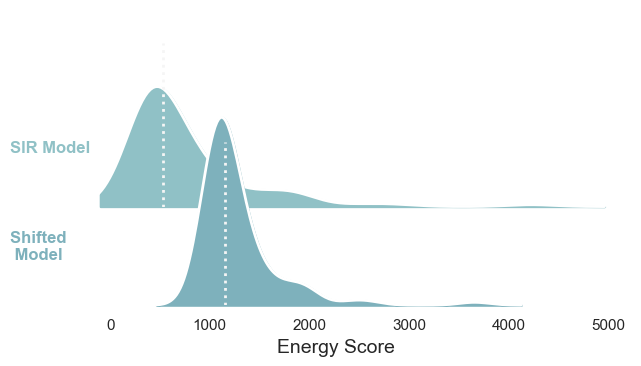

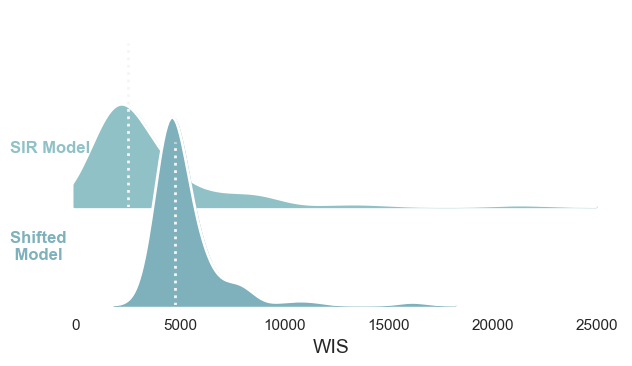

In [60]:
# plot distributions for energy score and WIS

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
dfs = [ESdf, WISdf]
scores = ['Energy Score', 'WIS']

i=1
#plt.subplots(1,2, figsize=(15,5))
for df in dfs:
    if i==1:
        maxi=10000
    else:
        maxi=110000
        
    df = df.copy()
    df['Model'] = df['Model'].apply(lambda x: 'SIR Model' if x == 'SIR' else 'Shifted \n Model')
    #plt.subplot(1,2,i)
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="Model", hue="Model", aspect=3.5, height=2, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "value",
          bw_adjust=1, clip_on=False,
          fill=True, alpha=1, linewidth=1.5, clip = (-100,maxi))
    g.map(sns.kdeplot, "value", clip_on=False, color="w", lw=2, bw_adjust=1, clip = (-500,maxi))


    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(-.05, .3, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "value")

    # Define a function to plot the median
    def plot_median(data, color, label):
        median = np.median(data['value'])
        plt.axvline(median,ymin=0, ymax=.83, color='whitesmoke', linestyle=':', linewidth=2)
        print(median)

    # Apply the function to plot the median
    g.map_dataframe(plot_median)


    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-.5)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    plt.xlabel(scores[i-1], fontsize=14)
    
   

  #  plt.savefig(f'../figs/dist_SIRtest_{scores[i-1]}.pdf')
    
    
    i+=1
    
    

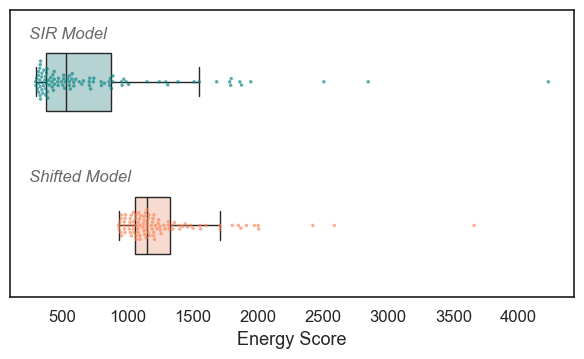

In [61]:
fig,ax = plt.subplots(figsize=(6,3.75))
palette = ['teal', 'coral']

df = ESdf.copy()


g=sns.boxplot(x='value', y='Model', data=df,hue='Model', width=0.4, showfliers=False, 
            palette=palette)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))


sns.swarmplot(x='value', y='Model', data=df,hue='Model', palette=palette,
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

a = 0
for mod in ['SIR Model', 'Shifted Model']:
    plt.text(250,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

#plt.xlim([0,3500])    
    
plt.xlabel('Energy Score', fontsize=13)
plt.xticks(fontsize=12)
#plt.legend(title=None)
plt.tight_layout()

#plt.savefig('../figs/sir_test_ES_boxplots_1115.pdf')
plt.show()

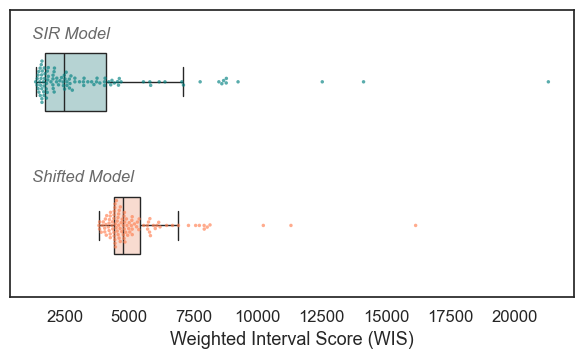

In [62]:
fig,ax = plt.subplots(figsize=(6,3.75))
palette = ['teal', 'coral']

df = WISdf.copy()

g=sns.boxplot(x='value', y='Model', data=WISdf,hue='Model', width=0.4, showfliers=False, 
            palette=palette)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))


sns.swarmplot(x='value', y='Model', data=WISdf,hue='Model', palette=palette,
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

#plt.xlim([0,17500])

a = 0
for mod in ['SIR Model', 'Shifted Model']:
    plt.text(1200,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1

plt.xlabel('Weighted Interval Score (WIS)', fontsize=13)
plt.xticks(fontsize=12)
#plt.legend(title=None)
plt.tight_layout()
#plt.savefig('../figs/sir_test_WIS_boxplots_1115.pdf')
plt.show()

In [63]:
dfSIR = ESdf[ESdf.Model=='SIR']
dfshifted = ESdf[ESdf.Model=='magnitude shifted SIR'].rename(columns={'value':'ES_shifted'})

dfratio = dfSIR.merge(dfshifted,on=['trajectory_id'])
dfratio['ratio'] = dfratio['ES_shifted'] / dfratio['value']
dfratio['score'] = 'Energy Score'

dfSIR = WISdf[WISdf.Model=='SIR']
dfshifted = WISdf[WISdf.Model=='magnitude shifted SIR'].rename(columns={'value':'WIS_shifted'})

dfratio_WIS = dfSIR.merge(dfshifted,on=['trajectory_id'])
dfratio_WIS['ratio'] = dfratio_WIS['WIS_shifted'] / dfratio_WIS['value']
dfratio_WIS['score'] = 'WIS'

dfratio = pd.concat([dfratio,dfratio_WIS])

Text(-36.25, 0.5, '')

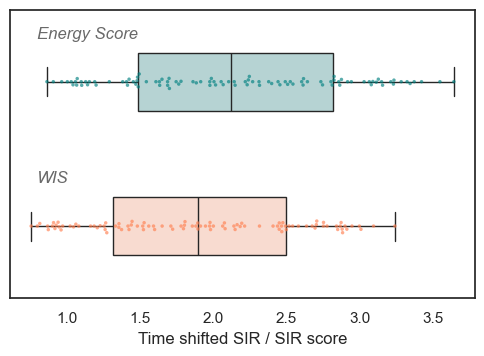

In [66]:
fig,ax = plt.subplots(figsize=(6,3.75))


palette = ['teal', 'coral']
g=sns.boxplot(x='ratio',y= 'score',data=dfratio,palette=palette,hue='score',width=.4)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))
    
sns.swarmplot(x='ratio',y= 'score',data=dfratio,palette=palette,hue='score',
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

a = 0
for mod in ['Energy Score', 'WIS']:
    plt.text(.8,a-.3, mod, fontsize=12, style='italic', color='dimgray')
    a+=1
    
    
plt.xlabel('Time shifted SIR / SIR score',fontsize=12)
plt.ylabel('')

<Figure size 800x600 with 0 Axes>

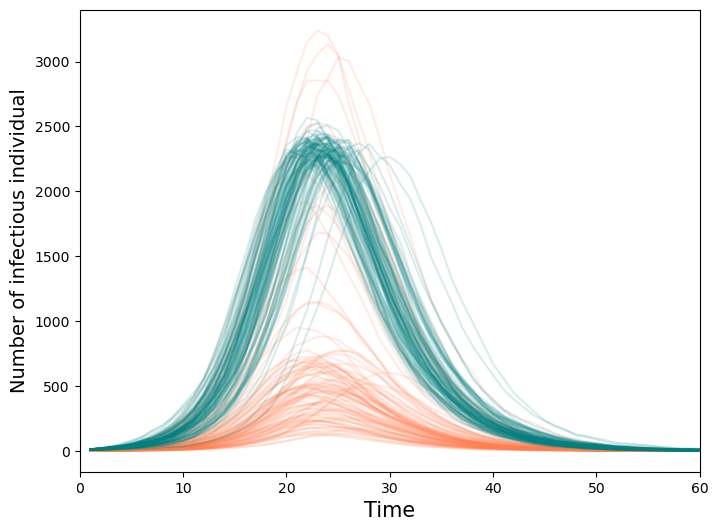

In [251]:
# example trajectories from SIR model
plt.figure(figsize=(8,6))
sim =200
Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)
#for n in range(sim):
 #   plt.plot(Iall[n], 'teal',linewidth=.75,  alpha=.5)
    
#plt.plot(Iall[n], 'teal',linewidth=.75, label='I', alpha=.5)

# only keep first 60 time steps
n=0
Ifilt = {}
for i in Iall.keys():
    if len(Iall[i])>=60:
        Ifilt[n] = Iall[i][0:60]
        n+=1
        
# save infection trajectories in dataframe
Idf = pd.DataFrame()
time = list(range(1, 61))

for it in range(1, 101):
    traj = Ifilt[it]

    for t in time:
        val = traj[t-1]

        newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
        Idf = pd.concat([Idf, newrow])

Ishift = pd.DataFrame()
for idx in Idf.trajectory_id.unique():

    if idx<=80:
        d = Idf[Idf.trajectory_id==idx]
        d['I'] = d['I'] * np.random.uniform(.05,.33)

        d['I'] = d['I'].apply(lambda key:  0 if key<0 else key)

    else:
        d = Idf[Idf.trajectory_id==idx]
        d['I'] = d['I'] * np.random.uniform(.33,1.5)

        d['I'] = d['I'].apply(lambda key:  0 if key<0 else key)

    Ishift = pd.concat([Ishift,d])


plt.figure(figsize=(8,6))
for i in Ishift.trajectory_id.unique():
    if i<500:
        d = Ishift[Ishift.trajectory_id==i].sort_values(by='time',ascending=True)
        plt.plot(d.time, d.I, color='coral', alpha=.15)
        
for i in Idf.trajectory_id.unique():
    if i<500:
        d = Idf[Idf.trajectory_id==i].sort_values(by='time',ascending=True)
        plt.plot(d.time, d.I, color='teal', alpha=.15)
        
        
plt.xlim([0,60])

plt.xlabel('Time',fontsize=15)
plt.ylabel('Number of infectious individual', fontsize=14)        


plt.show()

(0.0, 70.0)

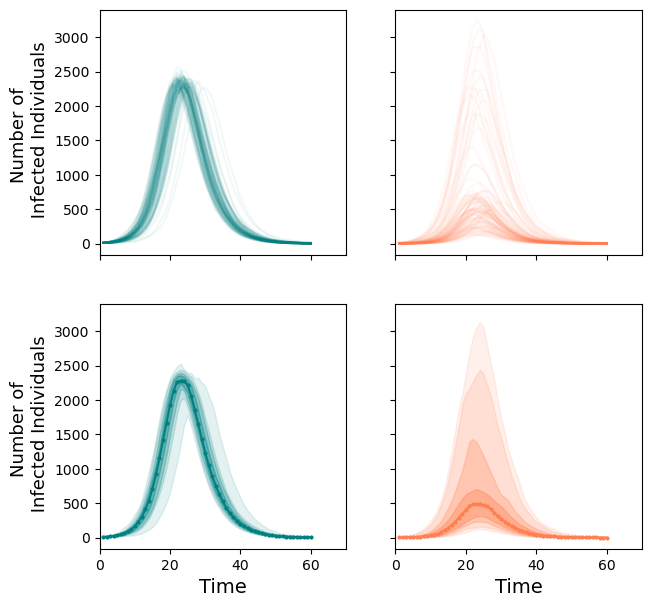

In [252]:
Ishift = Ishift.sort_values(by='time',ascending=True)

# plot all trajectories
fig,ax = plt.subplots(2,2, figsize=(7,7), sharey=True,sharex=True)

plt.subplot(2,2,1)
for i in Idf.trajectory_id.unique():
    if i<501:
        d = Idf[Idf.trajectory_id==i]
        plt.plot(d.time, d.I, color='teal', alpha=.05)
#plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of \n Infected Individuals', fontsize=13)
        

plt.subplot(2,2,2)
for i in Ishift.trajectory_id.unique():
    if i<501:
        d = Ishift[Ishift.trajectory_id==i]
        plt.plot(d.time, d.I, color='coral', alpha=.05)
#plt.xlabel('Time', fontsize=14)        
        
        
plt.subplot(2,2,3)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Idf.groupby('time')['I'].quantile(q[0]))
    qlow = list(Idf.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Idf.time.unique(),qupp,qlow, color='teal', alpha=alpha)
    
qmed = list(Idf.groupby('time')['I'].quantile(.5))

plt.plot(Idf.time.unique(),qmed,'-o', color='teal', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of \n Infected Individuals', fontsize=13)
 

plt.subplot(2,2,4)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Ishift.groupby('time')['I'].quantile(q[0]))
    qlow = list(Ishift.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Ishift.time.unique(),qupp,qlow, color='coral', alpha=alpha)
    
qmed = list(Ishift.groupby('time')['I'].quantile(.5))

plt.plot(Ishift.time.unique(),qmed,'-o', color='coral', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
#plt.ylabel('Number of Infected Individuals', fontsize=13)
plt.xlim([0,70])

In [213]:
# run SIR model and generate time shifted trajectories

def get_SIR_trajectories_lowmedian(sim=1000):

    #sim =200
    Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)

    n=0
    Ifilt = {}
    for i in Iall.keys():
        if len(Iall[i])>=60:
            Ifilt[n] = Iall[i][0:60]
            n+=1

    Idf = pd.DataFrame()
    time = list(range(1, 61))

    for it in range(1, 101):
        traj = Ifilt[it]

        for t in time:
            val = traj[t-1]

            newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])
            Idf = pd.concat([Idf, newrow])

    Ishift = pd.DataFrame()
    for idx in Idf.trajectory_id.unique():

        if idx<=80:
            d = Idf[Idf.trajectory_id==idx]
            d['I'] = d['I'] * np.random.uniform(.05,.33)

            d['I'] = d['I'].apply(lambda key:  0 if key<0 else key)

        else:
            d = Idf[Idf.trajectory_id==idx]
            d['I'] = d['I'] * np.random.uniform(.33,1.5)

            d['I'] = d['I'].apply(lambda key:  0 if key<0 else key)

        Ishift = pd.concat([Ishift,d])

    Idf['Model'] = 'SIR'
    Ishift['Model'] = 'magnitude shifted SIR'

    dftot = pd.concat([Idf, Ishift])
    
    dftot = dftot[(dftot.time>0) & (dftot.time<=60)]

    return dftot

In [217]:
# compute energy score and WIS for SIR and uncorrelated model
numit = 100

ES_SIR = []
ES_shift = []
WIS_SIR = []
WIS_shift = []

truth = []
for i in range(numit):
    
    y=np.array([])
    while y.shape[0]<60:
        # generate observation vector as single instance of SIR model
        Sall,Iall, Rall = SIR_model(nsim=1, beta=.625,mu=.25, pop=10000, nseed=10)
        y = np.array(Iall[0][0:60]).astype(float) 
        
    dftot = get_SIR_trajectories_lowmedian(sim=800)

    SIRdf = dftot[dftot.Model=='SIR']
    SIR_X = np.array([np.array(SIRdf[SIRdf['trajectory_id'] == i].I) for i in SIRdf['trajectory_id'].unique()]).astype(float) 
    
    shiftdf = dftot[dftot.Model=='magnitude shifted SIR']
    shift_X = np.array([np.array(shiftdf[shiftdf['trajectory_id'] == i].I) for i in shiftdf['trajectory_id'].unique()]).astype(float) 

    # calculate scores
    ES_SIR.append(energyscore(SIR_X ,y))
    ES_shift.append(energyscore(shift_X,y))
    WIS_SIR.append(WIS(SIR_X,y))
    WIS_shift.append(WIS(shift_X,y))
    

ESdf = pd.DataFrame({'Model':'SIR', 'value':ES_SIR,'trajectory_id': list(range(len(ES_SIR)))})
ESdf = pd.concat([ESdf,pd.DataFrame({'Model':'time shifted SIR', 'value':ES_shift,
                                     'trajectory_id':list(range(len(ES_shift)))})])


WISdf = pd.DataFrame({'Model':'SIR', 'value':WIS_SIR,'trajectory_id':list(range(len(WIS_SIR)))})
WISdf = pd.concat([WISdf,pd.DataFrame({'Model':'time shifted SIR', 'value':WIS_shift,
                                       'trajectory_id':list(range(len(WIS_shift)))})])

In [218]:
dfSIR = ESdf[ESdf.Model=='SIR']
dfshifted = ESdf[ESdf.Model=='time shifted SIR'].rename(columns={'value':'ES_shifted'})

dfratio = dfSIR.merge(dfshifted,on=['trajectory_id'])
dfratio['ratio'] = dfratio['ES_shifted'] / dfratio['value']
dfratio['score'] = 'Energy Score'

dfSIR = WISdf[WISdf.Model=='SIR']
dfshifted = WISdf[WISdf.Model=='time shifted SIR'].rename(columns={'value':'WIS_shifted'})

dfratio_WIS = dfSIR.merge(dfshifted,on=['trajectory_id'])
dfratio_WIS['ratio'] = dfratio_WIS['WIS_shifted'] / dfratio_WIS['value']
dfratio_WIS['score'] = 'WIS'

dfratio = pd.concat([dfratio,dfratio_WIS])

Text(-32.152777777777786, 0.5, '')

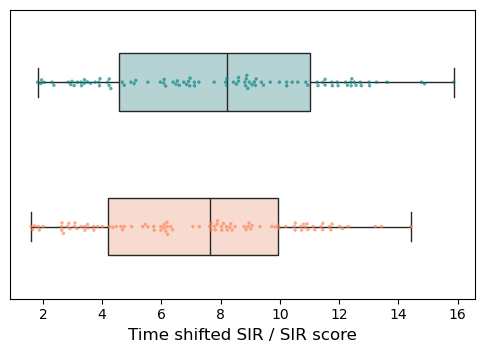

In [219]:
fig,ax = plt.subplots(figsize=(6,3.75))


palette = ['teal', 'coral']
g=sns.boxplot(x='ratio',y= 'score',data=dfratio,palette=palette,hue='score',width=.4)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))
    
sns.swarmplot(x='ratio',y= 'score',data=dfratio,palette=palette,hue='score',
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

a = 0
#for mod in ['Energy Score', 'WIS']:
 #   plt.text(.8,a-.3, mod, fontsize=12, style='italic', color='dimgray')
  #  a+=1
    
    
plt.xlabel('Time shifted SIR / SIR score',fontsize=12)
plt.ylabel('')

<Figure size 800x600 with 0 Axes>

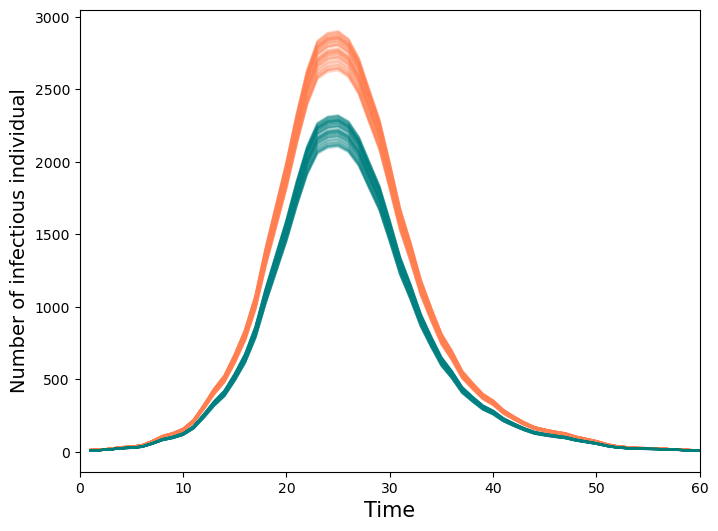

In [253]:
# example trajectories from SIR model
plt.figure(figsize=(8,6))
sim =1
Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)
#for n in range(sim):
 #   plt.plot(Iall[n], 'teal',linewidth=.75,  alpha=.5)
    
#plt.plot(Iall[n], 'teal',linewidth=.75, label='I', alpha=.5)

# only keep first 60 time steps
n=0
Ifilt = {}
for i in Iall.keys():
    if len(Iall[i])>=60:
        Ifilt[n] = Iall[i][0:60]
        n+=1
        
# save infection trajectories in dataframe
Idf = pd.DataFrame()

time = list(range(1, 61))

traj = Ifilt[0]
    
it=0
for t in time:
    val = traj[t-1]

    newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])

    Idf = pd.concat([Idf, newrow])


for it in range(100):    
    df = Idf[Idf.trajectory_id==0]
    df['trajectory_id'] = it
    
    Idf = pd.concat([Idf, df])
    
    
Idf_noise = pd.DataFrame()
for idx in Idf.trajectory_id.unique():
    
    d = Idf[Idf.trajectory_id==idx]
    d['I'] = d['I'] * np.random.uniform(.95,1.05)

    d['I'] = d['I'].apply(lambda key:  0 if key<0 else key)
    
    Idf_noise = pd.concat([Idf_noise,d])
    

Ishift = pd.DataFrame()
for idx in Idf_noise.trajectory_id.unique():
    
    d = Idf_noise[Idf_noise.trajectory_id==idx]
    d['I'] = d['I'] * 1.25

    d['I'] = d['I'].apply(lambda key:  0 if key<0 else key)

       

   # d['time'] = d['time'] + np.random.randint(-20, high=20)
    
    Ishift = pd.concat([Ishift,d])
    
        
plt.figure(figsize=(8,6))
for i in Ishift.trajectory_id.unique():
    if i<500:
        d = Ishift[Ishift.trajectory_id==i].sort_values(by='time',ascending=True)
        plt.plot(d.time, d.I, color='coral', alpha=.15)
        
for i in Idf_noise.trajectory_id.unique():
    if i<500:
        d = Idf_noise[Idf_noise.trajectory_id==i].sort_values(by='time',ascending=True)
        plt.plot(d.time, d.I, color='teal', alpha=.15)
        
        
plt.xlim([0,60])

plt.xlabel('Time',fontsize=15)
plt.ylabel('Number of infectious individual', fontsize=14)        


plt.show()

(0.0, 70.0)

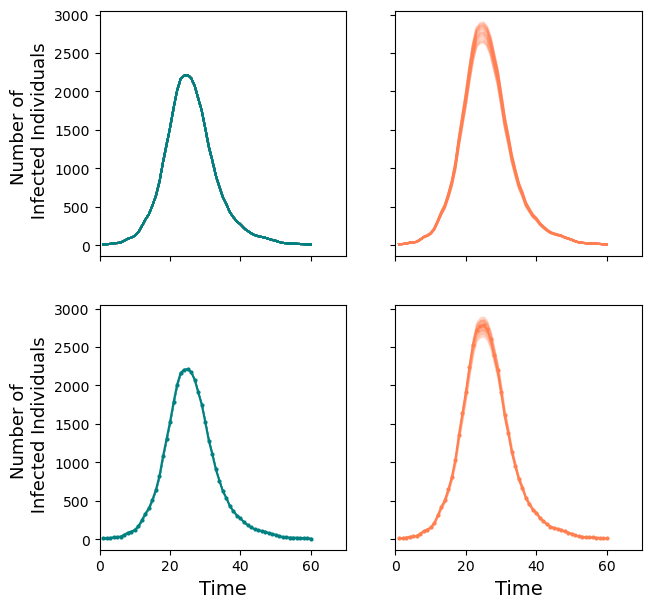

In [255]:
Ishift = Ishift.sort_values(by='time',ascending=True)

# plot all trajectories
fig,ax = plt.subplots(2,2, figsize=(7,7), sharey=True,sharex=True)

plt.subplot(2,2,1)
for i in Idf.trajectory_id.unique():
    if i<501:
        d = Idf[Idf.trajectory_id==i].sort_values(by='time',ascending=True)
        plt.plot(d.time, d.I, color='teal', alpha=.05)
#plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of \n Infected Individuals', fontsize=13)
        

plt.subplot(2,2,2)
for i in Ishift.trajectory_id.unique():
    if i<501:
        d = Ishift[Ishift.trajectory_id==i].sort_values(by='time',ascending=True)
        plt.plot(d.time, d.I, color='coral', alpha=.05)
#plt.xlabel('Time', fontsize=14)        
        
        
plt.subplot(2,2,3)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Idf.groupby('time')['I'].quantile(q[0]))
    qlow = list(Idf.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Idf.time.unique(),qupp,qlow, color='teal', alpha=alpha)
    
qmed = list(Idf.groupby('time')['I'].quantile(.5))

plt.plot(Idf.time.unique(),qmed,'-o', color='teal', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
plt.ylabel('Number of \n Infected Individuals', fontsize=13)
 

plt.subplot(2,2,4)
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1
quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]

for q in quants:
    interval_range = q[1] - q[0]
    alpha = map_alpha(interval_range)
    
    qupp = list(Ishift.groupby('time')['I'].quantile(q[0]))
    qlow = list(Ishift.groupby('time')['I'].quantile(q[1]))
    
    plt.fill_between(Ishift.time.unique(),qupp,qlow, color='coral', alpha=alpha)
    
qmed = list(Ishift.groupby('time')['I'].quantile(.5))

plt.plot(Ishift.time.unique(),qmed,'-o', color='coral', alpha=1,markersize=2,
                               label=fr"Quantile projections")

plt.xlabel('Time', fontsize=14)
#plt.ylabel('Number of Infected Individuals', fontsize=13)
plt.xlim([0,70])

In [240]:
# run SIR model and generate time shifted trajectories

def get_SIR_trajectories_overconfident(sim=1000):

    #sim =200
    sim =1
    
    obs = 0
    while obs<60:
    
        Sall,Iall, Rall = SIR_model(nsim=sim, beta=.625,mu=.25, pop=10000, nseed=10)
        
        obs = len(Iall[0])
    #for n in range(sim):
     #   plt.plot(Iall[n], 'teal',linewidth=.75,  alpha=.5)

    #plt.plot(Iall[n], 'teal',linewidth=.75, label='I', alpha=.5)

    # only keep first 60 time steps
    n=0
    Ifilt = {}
    for i in Iall.keys():
        if len(Iall[i])>=60:
            Ifilt[n] = Iall[i][0:60]
            n+=1

    # save infection trajectories in dataframe
    Idf = pd.DataFrame()

    time = list(range(1, 61))

    traj = Ifilt[0]

    it=0
    for t in time:
        val = traj[t-1]

        newrow = pd.DataFrame({'trajectory_id':it, 'time':t, 'I':val}, index=[0])

        Idf = pd.concat([Idf, newrow])


    for it in range(100): 
        if it==0:
            continue
        
        df = Idf[Idf.trajectory_id==0]
        df['trajectory_id'] = it

        Idf = pd.concat([Idf, df])


    Idf_noise = pd.DataFrame()
    for idx in Idf.trajectory_id.unique():

        d = Idf[Idf.trajectory_id==idx]
        d['I'] = d['I'] * np.random.uniform(.95,1.05)

        d['I'] = d['I'].apply(lambda key:  0 if key<0 else key)

        Idf_noise = pd.concat([Idf_noise,d])


    Ishift = pd.DataFrame()
    for idx in Idf_noise.trajectory_id.unique():

        d = Idf_noise[Idf_noise.trajectory_id==idx]
        d['I'] = d['I'] * 1.25

        d['I'] = d['I'].apply(lambda key:  0 if key<0 else key)



       # d['time'] = d['time'] + np.random.randint(-20, high=20)

        Ishift = pd.concat([Ishift,d])


    Idf_noise['Model'] = 'SIR'
    Ishift['Model'] = 'magnitude shifted SIR'

    dftot = pd.concat([Idf_noise, Ishift])
    
    dftot = dftot[(dftot.time>0) & (dftot.time<=60)]

    return dftot

In [241]:
# compute energy score and WIS for SIR and uncorrelated model
numit = 100

ES_SIR = []
ES_shift = []
WIS_SIR = []
WIS_shift = []

truth = []
for i in range(numit):
    
    y=np.array([])
    while y.shape[0]<60:
        # generate observation vector as single instance of SIR model
        Sall,Iall, Rall = SIR_model(nsim=1, beta=.625,mu=.25, pop=10000, nseed=10)
        y = np.array(Iall[0][0:60]).astype(float) 
        
    dftot = get_SIR_trajectories_overconfident(sim=800)

    SIRdf = dftot[dftot.Model=='SIR']
    SIR_X = np.array([np.array(SIRdf[SIRdf['trajectory_id'] == i].I) for i in SIRdf['trajectory_id'].unique()]).astype(float) 
    
    shiftdf = dftot[dftot.Model=='magnitude shifted SIR']
    shift_X = np.array([np.array(shiftdf[shiftdf['trajectory_id'] == i].I) for i in shiftdf['trajectory_id'].unique()]).astype(float) 

    # calculate scores
    ES_SIR.append(energyscore(SIR_X ,y))
    ES_shift.append(energyscore(shift_X,y))
    WIS_SIR.append(WIS(SIR_X,y))
    WIS_shift.append(WIS(shift_X,y))
    

ESdf = pd.DataFrame({'Model':'SIR', 'value':ES_SIR,'trajectory_id': list(range(len(ES_SIR)))})
ESdf = pd.concat([ESdf,pd.DataFrame({'Model':'time shifted SIR', 'value':ES_shift,
                                     'trajectory_id':list(range(len(ES_shift)))})])


WISdf = pd.DataFrame({'Model':'SIR', 'value':WIS_SIR,'trajectory_id':list(range(len(WIS_SIR)))})
WISdf = pd.concat([WISdf,pd.DataFrame({'Model':'time shifted SIR', 'value':WIS_shift,
                                       'trajectory_id':list(range(len(WIS_shift)))})])

In [242]:
dfSIR = ESdf[ESdf.Model=='SIR']
dfshifted = ESdf[ESdf.Model=='time shifted SIR'].rename(columns={'value':'ES_shifted'})

dfratio = dfSIR.merge(dfshifted,on=['trajectory_id'])
dfratio['ratio'] = dfratio['ES_shifted'] / dfratio['value']
dfratio['score'] = 'Energy Score'

dfSIR = WISdf[WISdf.Model=='SIR']
dfshifted = WISdf[WISdf.Model=='time shifted SIR'].rename(columns={'value':'WIS_shifted'})

dfratio_WIS = dfSIR.merge(dfshifted,on=['trajectory_id'])
dfratio_WIS['ratio'] = dfratio_WIS['WIS_shifted'] / dfratio_WIS['value']
dfratio_WIS['score'] = 'WIS'

dfratio = pd.concat([dfratio,dfratio_WIS])

Text(-32.152777777777786, 0.5, '')

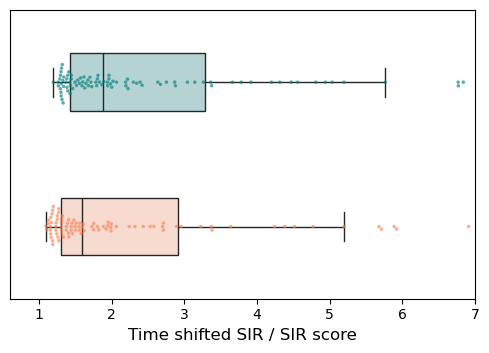

In [245]:
fig,ax = plt.subplots(figsize=(6,3.75))


palette = ['teal', 'coral']
g=sns.boxplot(x='ratio',y= 'score',data=dfratio,palette=palette,hue='score',width=.4,showfliers=False)

for patch in ax.patches:
    r, gr, b, a = patch.get_facecolor()
    patch.set_facecolor((r, gr, b, .3))
    
sns.swarmplot(x='ratio',y= 'score',data=dfratio,palette=palette,hue='score',
              alpha = .65,size=2.5, orient="h",)    

g.set(ylabel=None)
g.set(yticklabels=[])
g.set(yticks=[])

a = 0
#for mod in ['Energy Score', 'WIS']:
 #   plt.text(.8,a-.3, mod, fontsize=12, style='italic', color='dimgray')
  #  a+=1
    
plt.xlim([0.6,7])
plt.xlabel('Time shifted SIR / SIR score',fontsize=12)
plt.ylabel('')